In [36]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pathlib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

In [2]:
# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load Data

In [3]:
# get the data directory
data_dir = pathlib.Path(os.getcwd()).parent / "data"
oni_file = data_dir / "processed_data" / "ocean_nino_index.csv"
combined_file = data_dir / "processed_data" / "combined_data.nc"

In [4]:
# Load the data
oni = pd.read_csv(oni_file, index_col=0, parse_dates=True)
combined = xr.open_dataset(combined_file)

# Feature Engineering

In [5]:
# Shift the data along the time dimension for different variables
lead_time = 3

# Precipitation shifted by 3 months into the future
precip_3months_future = combined["tp"].shift(time=-lead_time)  # Target variable
precip_12months_past = combined["tp"].shift(time=12 - lead_time)

# Thickness of the atmosphere layer
thickness_11months_past = combined["thickness"].shift(time=11 - lead_time)
thickness_5months_past = combined["thickness"].shift(time=5 - lead_time)

# Precipitable water data from 11 and 6 months ago
precipitable_water_11months_past = combined["pr_wtr"].shift(time=11 - lead_time)
precipitable_water_6months_past = combined["pr_wtr"].shift(
    time=6 - lead_time
)  # Fixed to match 6 months

# Lifted index data from 5 and 12 months ago
lifted_index_5months_past = combined["lftx4"].shift(time=5 - lead_time)
lifted_index_12months_past = combined["lftx4"].shift(time=12 - lead_time)

# Velocity potential data from 5 and 11 months ago
velocity_potential_5months_past = combined["chi"].shift(time=5 - lead_time)
velocity_potential_11months_past = combined["chi"].shift(time=11 - lead_time)

# Specific humidity data from 11 and 5 months ago
specific_humidity_11months_past = combined["shum"].shift(time=11 - lead_time)
specific_humidity_5months_past = combined["shum"].shift(time=5 - lead_time)

# Add the shifted features back to dataset
combined = combined.assign(
    precip_3months_future=precip_3months_future,
    precip_12months_past=precip_12months_past,
    thickness_11months_past=thickness_11months_past,
    thickness_5months_past=thickness_5months_past,
    precipitable_water_11months_past=precipitable_water_11months_past,
    precipitable_water_6months_past=precipitable_water_6months_past,
    lifted_index_5months_past=lifted_index_5months_past,
    lifted_index_12months_past=lifted_index_12months_past,
    velocity_potential_5months_past=velocity_potential_5months_past,
    velocity_potential_11months_past=velocity_potential_11months_past,
    specific_humidity_11months_past=specific_humidity_11months_past,
    specific_humidity_5months_past=specific_humidity_5months_past,
)

# Transform Data

In [6]:
# Stack the dimensions (latitude, longitude, and time)
data_df = combined.stack(
    stacked_dim=(
        "time",
        "latitude",
        "longitude",
    )
).to_dataframe()

# get year and month as columns
data_df["year"] = data_df["time"].dt.year
data_df["month"] = data_df["time"].dt.month
data_df.drop("level", axis=1, inplace=True)

# Clean up DataFrame
data_df = pd.DataFrame(data_df.values, columns=data_df.columns)

# Merge the ONI data with the combined data
data_df = pd.merge(data_df, oni["oni"], left_on="time", right_index=True, how="left")

In [7]:
data_df.head()

,tp,thickness,pr_wtr,lftx4,chi,tcdc,shum,precip_3months_future,precip_12months_past,thickness_11months_past,...,velocity_potential_5months_past,velocity_potential_11months_past,specific_humidity_11months_past,specific_humidity_5months_past,time,latitude,longitude,year,month,oni
0,45.927555,4106.09668,5.836773,4.779999,3956104.0,41.632202,3.130437,14.142419,NaN,NaN,...,NaN,NaN,NaN,NaN,1982-01-01,37.5,-110.0,1982,1,0.0
1,130.154694,4106.225586,4.658706,3.579987,3746255.0,36.85997,2.960092,49.506752,NaN,NaN,...,NaN,NaN,NaN,NaN,1982-01-01,37.5,-107.5,1982,1,0.0
2,26.884987,4109.709473,4.588711,4.059998,3477865.0,31.162931,3.099163,65.091698,NaN,NaN,...,NaN,NaN,NaN,NaN,1982-01-01,37.5,-105.0,1982,1,0.0
3,6.728515,4112.483887,6.329677,7.019989,3321464.0,31.306482,3.192048,38.366871,NaN,NaN,...,NaN,NaN,NaN,NaN,1982-01-01,37.5,-102.5,1982,1,0.0
4,9.260784,4112.612793,8.125804,10.51001,3280527.0,33.535839,3.203131,47.486332,NaN,NaN,...,NaN,NaN,NaN,NaN,1982-01-01,37.5,-100.0,1982,1,0.0


# Data Preprocessing

In [8]:
# Number of months in a year
n_months = 12

# Create sine and cosine transformations for the month variable
data_df["month_sin"] = np.sin(2 * np.pi * data_df["month"].astype(int) / n_months)
data_df["month_cos"] = np.cos(2 * np.pi * data_df["month"].astype(int) / n_months)

In [9]:
# Convert latitude and longitude to radians
lat_rad = np.radians(data_df["latitude"].astype(float))
lon_rad = np.radians(data_df["longitude"].astype(float))

# Apply sine and cosine encoding
data_df["lat_sin"] = np.sin(lat_rad)
data_df["lat_cos"] = np.cos(lat_rad)
data_df["lon_sin"] = np.sin(lon_rad)
data_df["lon_cos"] = np.cos(lon_rad)

In [10]:
# drop rows with missing values, values occur due to shifting
data_df.dropna(inplace=True)

# Parse time-space identifiers to rebuild the dataset later
location_df = data_df[["time", "latitude", "longitude"]]

In [11]:
# Convert the time dimension to a pandas datetime format (if not already)
time_df = pd.to_datetime(combined["time"])

# Define the indices for the 90% and 80% cutoffs
test_cutoff_idx = int(0.9 * len(time_df))
val_cutoff_idx = int(0.8 * len(time_df))

# Define the cutoff dates for splitting
test_cutoff_date = time_df[test_cutoff_idx]
val_cutoff_date = time_df[val_cutoff_idx]

# Display the cutoff dates
print(f"Test cutoff date: {test_cutoff_date}")
print(f"Validation cutoff date: {val_cutoff_date}")

Test cutoff date: 2019-10-01 00:00:00
Validation cutoff date: 2015-08-01 00:00:00


In [12]:
# Split data into training, validation, and test sets based on time
test_df = data_df[data_df["time"] >= test_cutoff_date]
val_df = data_df[
    (data_df["time"] >= val_cutoff_date) & (data_df["time"] < test_cutoff_date)
]
train_df = data_df[data_df["time"] < val_cutoff_date]

# Filter test set to only include June, July, and August (summer months)
test_df = test_df[test_df["month"].isin([6 - lead_time, 7 - lead_time, 8 - lead_time])]

# Get test time-space identifiers
test_location_df = test_df[["time", "latitude", "longitude"]]

# Extract the features for scaling (dropping time, latitude, longitude as they are not model features)
train_features = train_df.drop(columns=["time", "latitude", "longitude"])
val_features = val_df.drop(columns=["time", "latitude", "longitude"])
test_features = test_df.drop(columns=["time", "latitude", "longitude"])

In [13]:
# Initialize scalers for features and target
feature_scaler = StandardScaler()
target_scaler = MinMaxScaler()

# Fit scalers on the training data
train_scaled_features = feature_scaler.fit_transform(
    train_features.drop(columns=["precip_3months_future"])
)
val_scaled_features = feature_scaler.transform(
    val_features.drop(columns=["precip_3months_future"])
)
test_scaled_features = feature_scaler.transform(
    test_features.drop(columns=["precip_3months_future"])
)

train_scaled_target = target_scaler.fit_transform(
    train_features[["precip_3months_future"]]
)
val_scaled_target = target_scaler.transform(val_features[["precip_3months_future"]])
test_scaled_target = target_scaler.transform(test_features[["precip_3months_future"]])

# Convert scaled features and targets to DataFrames for easier tracking (if needed)
train_scaled_df = pd.DataFrame(
    train_scaled_features,
    columns=train_features.drop(columns=["precip_3months_future"]).columns,
)
val_scaled_df = pd.DataFrame(
    val_scaled_features,
    columns=val_features.drop(columns=["precip_3months_future"]).columns,
)
test_scaled_df = pd.DataFrame(
    test_scaled_features,
    columns=test_features.drop(columns=["precip_3months_future"]).columns,
)

# Model Training

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size=1, hidden_size=128, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # linear -> relu -> dropout
        x = self.bn1(self.dropout1(F.relu(self.fc1(x))))
        x = self.bn2(self.dropout2(F.relu(self.fc2(x))))
        x = self.fc3(x)
        return x

In [15]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [16]:
class EarlyStopper:
    def __init__(
        self, patience: int = 1, min_delta: float = 0.0, verbose: bool = False
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.best_model_weights = None
        self.verbose = verbose

    def early_stop(self, loss: float, model: nn.Module):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early Stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [17]:
# Training and Validation Functions
def train_regression(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x_train, y_train in data_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


def validate_regression(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [18]:
# Create datasets for DataLoader
train_features_tensor = torch.FloatTensor(train_scaled_features)
train_targets_tensor = torch.FloatTensor(train_scaled_target)

val_features_tensor = torch.FloatTensor(val_scaled_features)
val_targets_tensor = torch.FloatTensor(val_scaled_target)

test_features_tensor = torch.FloatTensor(test_scaled_features)
test_targets_tensor = torch.FloatTensor(test_scaled_target)

# Create dataset instances
train_dataset = CustomDataset(train_features_tensor, train_targets_tensor)
val_dataset = CustomDataset(val_features_tensor, val_targets_tensor)
test_dataset = CustomDataset(test_features_tensor, test_targets_tensor)

# Initialize DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_scaled_features.shape[1]
n_epochs = 700
patience = 10

model = NeuralNetwork(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

early_stopper = EarlyStopper(patience=patience)

In [20]:
# Training Loop
train_losses, val_losses = [], []
for epoch in range(n_epochs):
    train_loss = train_regression(model, train_loader, optimizer, criterion, device)
    val_loss = validate_regression(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step()

    if early_stopper.early_stop(val_loss, model):
        print(f"Early stopping at epoch {epoch}")
        break

early_stopper.restore_best_weights(model)

Early stopping at epoch 29


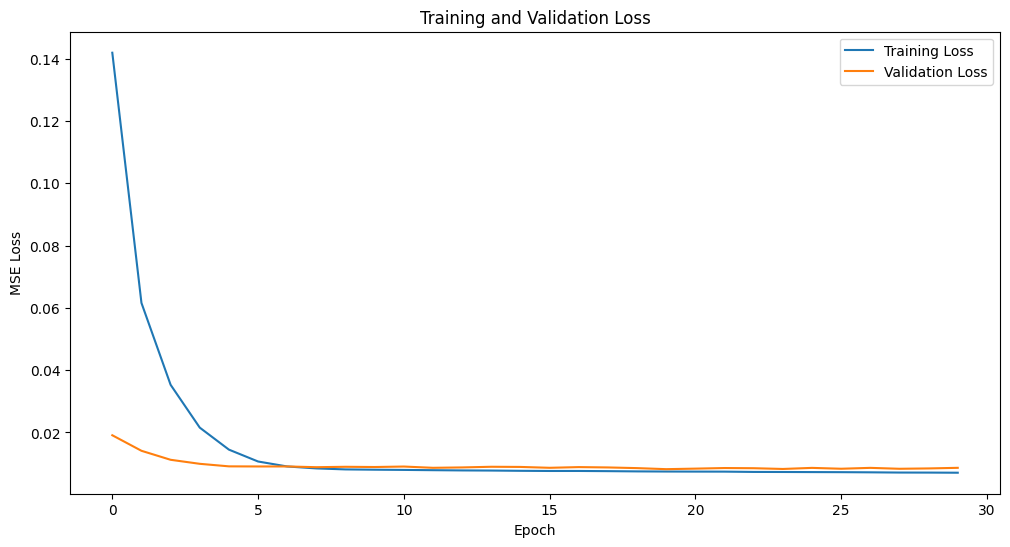

In [21]:
# Plot the training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Inference

In [22]:
# Predictions
def predict(model, data_loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y_hat = model(x)
            predictions.append(y_hat.cpu().numpy())
            actuals.append(y.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

In [23]:
y_train_hat, y_train_actual = predict(
    model, DataLoader(train_dataset, batch_size=batch_size), device
)
y_val_hat, y_val_actual = predict(model, val_loader, device)
y_test_hat, y_test_actual = predict(
    model, DataLoader(test_dataset, batch_size=batch_size), device
)

# Evaluation

In [24]:
# Inverse scaling
y_train_hat = target_scaler.inverse_transform(y_train_hat)
y_train_actual = target_scaler.inverse_transform(y_train_actual)
y_val_hat = target_scaler.inverse_transform(y_val_hat)
y_val_actual = target_scaler.inverse_transform(y_val_actual)
y_test_hat = target_scaler.inverse_transform(y_test_hat)
y_test_actual = target_scaler.inverse_transform(y_test_actual)

In [25]:
# Calculate MSE and ME for the test set
test_residuals = y_test_actual - y_test_hat
test_mse = np.mean((y_test_actual - y_test_hat) ** 2)
test_me = np.mean(y_test_actual - y_test_hat)
test_rmse = np.sqrt(test_mse)

# Print the results
print("Test Mean Squared Error:", test_mse)
print("Test Root Mean Squared Error:", test_rmse)
print("Test Mean Error:", test_me)

Test Mean Squared Error: 1051.3518
Test Root Mean Squared Error: 32.424557
Test Mean Error: -7.771725


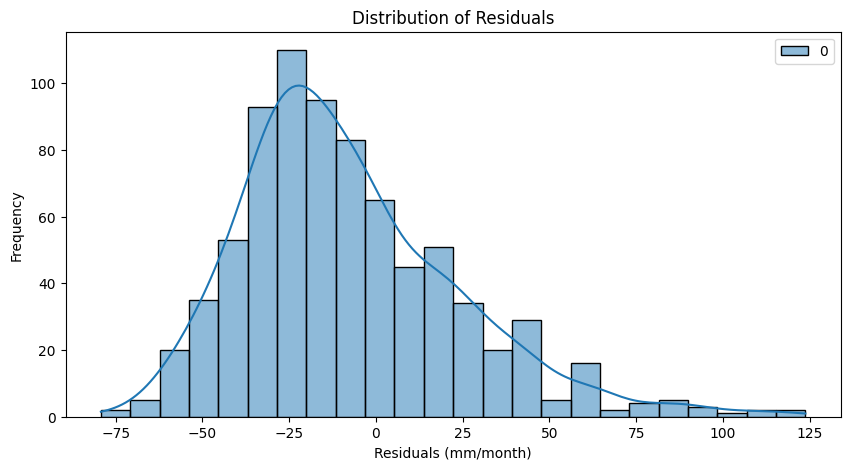

In [26]:
# Plot the residuals
plt.figure(figsize=(10, 5))
sns.histplot(test_residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (mm/month)")
plt.ylabel("Frequency")
plt.show()

In [32]:
# Ensure test_residuals is a DataFrame with a proper column name
residuals_df = pd.DataFrame(test_residuals, columns=["residuals"])

# Combine the time-space identifiers with the residuals
residuals_3d = pd.concat(
    [test_location_df.reset_index(drop=True), residuals_df.reset_index(drop=True)],
    axis=1,
)

# Group by latitude and longitude and calculate the mean of the residuals
mean_spatial_residuals = residuals_3d.groupby(
    ["latitude", "longitude"], as_index=False
)["residuals"].mean()
mean_spatial_residuals.rename(columns={"residuals": "mean_residuals"}, inplace=True)

# Get timeseries of residuals for the test set
test_residuals_timeseries = residuals_3d.groupby("time", as_index=False)[
    "residuals"
].mean()

# Create a grid for plotting
grid_latitude = mean_spatial_residuals["latitude"].unique()
grid_longitude = mean_spatial_residuals["longitude"].unique()

# Create a 2D array of mean residuals
mean_residuals_grid = mean_spatial_residuals.pivot(
    index="latitude", columns="longitude", values="mean_residuals"
)

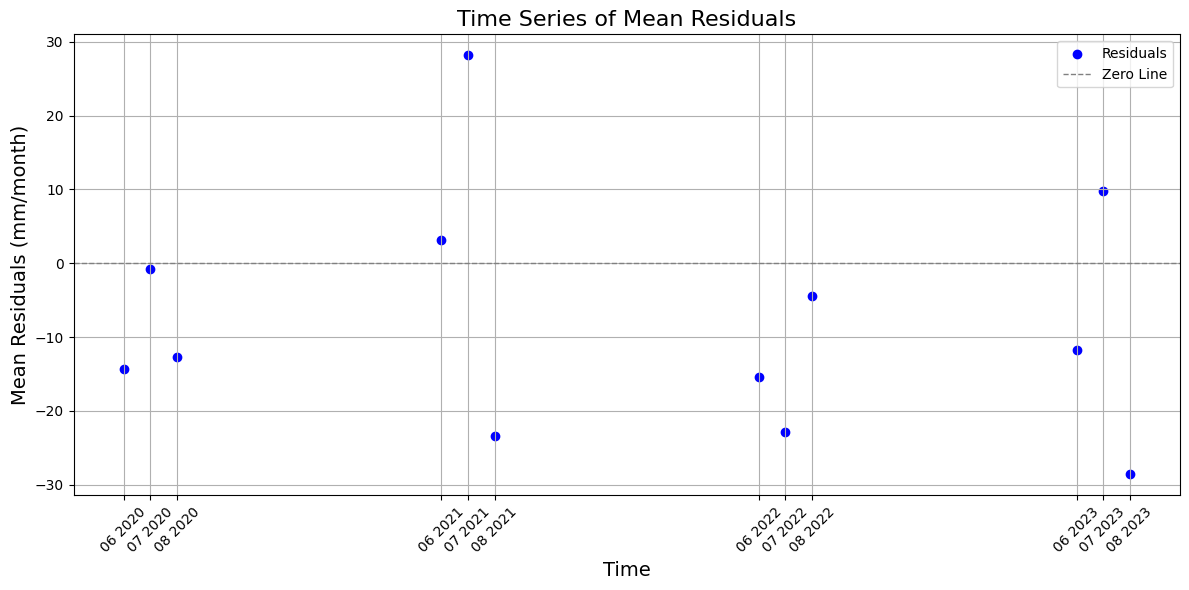

In [40]:
# Plot time series of residuals
plt.figure(figsize=(12, 6))

# Scatter plot of residuals
plt.scatter(
    test_residuals_timeseries["time"],
    test_residuals_timeseries["residuals"],
    color="blue",
    label="Residuals",
)

# Add a horizontal dashed line at y=0
plt.axhline(0, color="gray", linestyle="--", linewidth=1, label="Zero Line")

# Set title and labels
plt.title("Time Series of Mean Residuals", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Mean Residuals (mm/month)", fontsize=14)

# Set the x-ticks to only show June, July, and August
# Extract unique years from the time data
years = test_residuals_timeseries["time"].dt.year.unique()

# Create x-ticks and labels for each summer month in the unique years
x_ticks = []
x_labels = []

for year in years:
    for month in ["06", "07", "08"]:  # June, July, August
        date_str = f"{year}-{month}-01"
        x_ticks.append(pd.to_datetime(date_str))  # Append the date
        x_labels.append(f"{month} {year}")  # Create label for the tick

# Set the ticks and labels
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

# Add grid for better visibility
plt.grid()

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

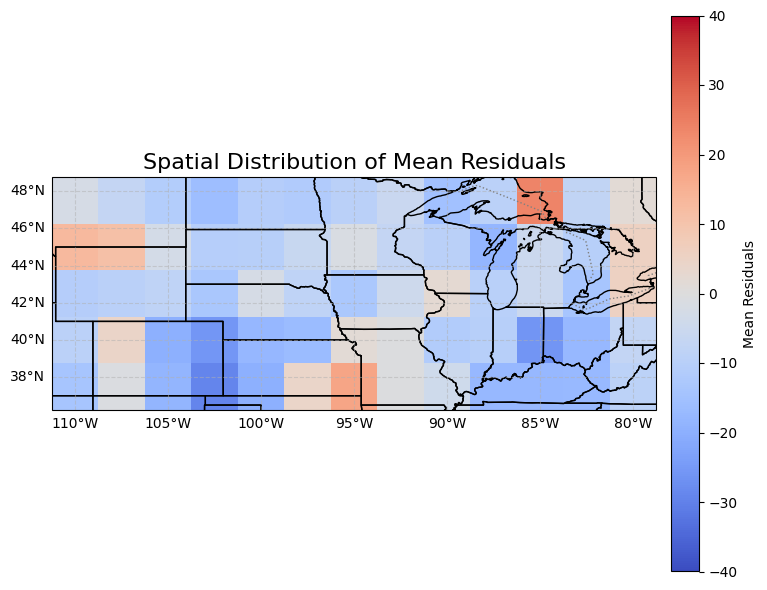

In [31]:
# Create a figure and axis with the PlateCarree projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the mean residuals using pcolormesh
c = ax.pcolormesh(
    mean_residuals_grid.columns,
    mean_residuals_grid.index,
    mean_residuals_grid.values,
    cmap="coolwarm",
    shading="auto",
    vmin=-40,
    vmax=40,
)  # Use shading='auto' for smoother edges

# Add color bar
cbar = plt.colorbar(c, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Mean Residuals")

# Add geographic features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")  # Country borders
ax.add_feature(cfeature.STATES, edgecolor="black")  # State boundaries
ax.coastlines()

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Title for the plot
ax.set_title("Spatial Distribution of Mean Residuals", fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()